In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:

from tensorflow.keras.applications import InceptionV3

pre_model = InceptionV3(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = 'imagenet')

# Make all the layers in the pre-model non-trainable
for layer in pre_model.layers:
    layer.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
pre_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:

last_layer = pre_model.get_layer('batch_normalization_87')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 384)


In [ ]:
loss = 'mean_squared_error'
metrics = ['mse','mae']
batch_size=64
epochs = 10

In [ ]:
from tensorflow.keras.optimizers import Adam

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.4
x = layers.Dropout(0.4)(x)                  
# Add a final linear layer for classification
x = layers.Dense  (1, activation='linear')(x) 
model = Model(pre_model.input, x)

model.compile(optimizer = tf.keras.optimizers.Adam(0.01), 
              loss = 'mean_squared_error',
              metrics = metrics) 

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
raw_dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SDSS.csv")
train_df = raw_dataset.copy()
train_df

,img_path,z
0,/content/drive/MyDrive/Colab Notebooks/galaxy_...,0.037450
1,/content/drive/MyDrive/Colab Notebooks/galaxy_...,-99.990000
2,/content/drive/MyDrive/Colab Notebooks/galaxy_...,0.029610
3,/content/drive/MyDrive/Colab Notebooks/galaxy_...,0.002882
4,/content/drive/MyDrive/Colab Notebooks/galaxy_...,0.038340
...,...,...
4453,/content/drive/MyDrive/Colab Notebooks/galaxy_...,-100.000000
4454,/content/drive/MyDrive/Colab Notebooks/galaxy_...,-99.990000
4455,/content/drive/MyDrive/Colab Notebooks/galaxy_...,0.024300
4456,/content/drive/MyDrive/Colab Notebooks/galaxy_...,0.022220


In [ ]:
import numpy as np
cnt=0
for row in train_df['z']:
    try:
        if row==-99.990000 or row==-100.000000 :
          train_df.loc[cnt, 'z']=np.nan
    except ValueError:
        pass
    cnt+=1

In [ ]:
train_df.isna().sum()

img_path       0
z           1357
dtype: int64

In [ ]:
# median = train_df['z'].median()
# train_df['z'].fillna(median, inplace=True)
train_df = train_df.dropna()

In [ ]:
train_df.isna().sum()

img_path    0
z           0
dtype: int64

In [ ]:
dataset=train_df.copy()

In [ ]:
train_df = dataset.sample(frac=0.8, random_state=0)
test_df = dataset.drop(train_df.index)

In [ ]:
datagen = ImageDataGenerator( 
            rescale=1./255.,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            validation_split=0.35,
            fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
            dataframe=train_df,
            directory=None,
            x_col="img_path",
            y_col="z",
            subset="training",
            batch_size=32,
            seed=42,
            shuffle=True,
            class_mode="other",
            target_size=(224,224))

valid_generator=datagen.flow_from_dataframe(
            dataframe=train_df,
            directory=None,
            x_col="img_path",
            y_col="z",
            subset="validation",
            batch_size=32,
            seed=42,
            class_mode="other",
            target_size=(224,224))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory=None,
            x_col="img_path",
            y_col=None,
            batch_size=batch_size,
            seed=42,
            class_mode=None,
            target_size=(224,224))           

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 1613 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 868 validated image filenames.
Found 620 validated image filenames.


In [ ]:
from keras.callbacks import EarlyStopping
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

# class myCallback(tf.keras.callbacks.Callback): 
#     def on_epoch_end(self, epoch, logs={}): 
#         if(logs.get('loss') < 0.001):   
#           print("\nReached %2.2f%% loss, so stopping training!!" %(0.001*100))   
#           self.model.stop_training = True

# callbacks = myCallback()

In [ ]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=50,
                    steps_per_epoch=10,
                    verbose=1,
                    callbacks=[earlystopper])

Epoch 1/50
10/10 [==============================] - 271s 29s/step - loss: 71191.2868 - mse: 71191.2868 - mae: 134.7923 - val_loss: 421.6995 - val_mse: 421.6995 - val_mae: 16.5948
Epoch 2/50
10/10 [==============================] - 149s 16s/step - loss: 577.3717 - mse: 577.3717 - mae: 18.7826 - val_loss: 74.5117 - val_mse: 74.5117 - val_mae: 7.9414
Epoch 3/50
10/10 [==============================] - 144s 15s/step - loss: 137.8472 - mse: 137.8472 - mae: 8.8272 - val_loss: 109.9153 - val_mse: 109.9153 - val_mae: 3.3061
Epoch 4/50
10/10 [==============================] - 139s 15s/step - loss: 217.0079 - mse: 217.0079 - mae: 6.2149 - val_loss: 18.2492 - val_mse: 18.2492 - val_mae: 2.1236
Epoch 5/50
10/10 [==============================] - 134s 14s/step - loss: 24.2037 - mse: 24.2037 - mae: 3.2517 - val_loss: 5.1073 - val_mse: 5.1073 - val_mae: 1.3821
Epoch 6/50
10/10 [==============================] - 132s 14s/step - loss: 38.6421 - mse: 38.6421 - mae: 2.5760 - val_loss: 7.9034 - val_mse: 7

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mse,mae,val_loss,val_mse,val_mae,epoch
0,39903.285156,39903.285156,93.533028,421.699524,421.699524,16.594793,0
1,428.451294,428.451294,15.618639,74.511688,74.511688,7.941419,1
2,101.561798,101.561798,7.236184,109.915329,109.915329,3.306091,2
3,130.551529,130.551529,5.604080,18.249210,18.249210,2.123604,3
4,17.059872,17.059872,2.760267,5.107337,5.107337,1.382085,4
5,27.327976,27.327976,2.338007,7.903427,7.903427,1.294164,5
6,33.184906,33.184906,2.092813,6.328862,6.328862,1.115795,6
7,14.852046,14.852046,1.768160,3.791919,3.791919,0.910837,7
8,13.952230,13.952230,1.367309,9.230388,9.230388,1.173616,8
9,12.437210,12.437210,1.438085,25.378628,25.378628,1.129460,9


In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Err [z]')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Err [$z^2$]')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
  plt.legend()



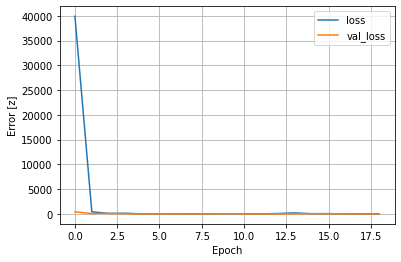

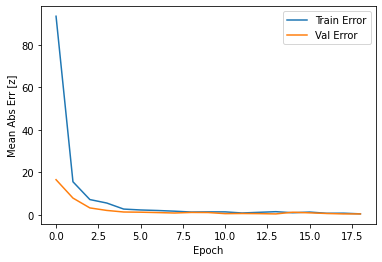

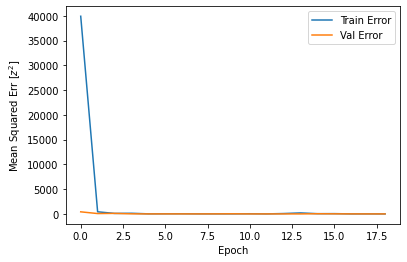

In [ ]:
plot_loss(history)

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/MainZmodel_inceptionV3")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MainZmodel_inceptionV3/assets


In [ ]:
test_features = test_df.copy()
test_labels = test_features.pop('z')

In [ ]:
test_predictions = model.predict(test_generator)


In [ ]:
test_predictions

array([[-6.89580619e-01],
       [ 6.16016209e-01],
       [ 6.74431801e-01],
       [ 3.08309108e-01],
       [-1.14532032e+01],
       [ 1.23338334e-01],
       [ 1.69409677e-01],
       [ 5.91128051e-01],
       [ 1.68700978e-01],
       [-8.06623474e-02],
       [ 1.53244734e-01],
       [ 4.61220071e-02],
       [ 7.84413069e-02],
       [ 1.26572609e-01],
       [ 6.80364549e-01],
       [-1.02848798e-01],
       [ 2.96872199e-01],
       [-3.00993398e-02],
       [-2.93173455e-02],
       [ 3.41487497e-01],
       [ 5.32430336e-02],
       [-1.36850908e-01],
       [ 4.36026365e-01],
       [-1.82351157e-01],
       [ 5.99577844e-01],
       [ 2.92214379e-03],
       [ 2.92418981e+00],
       [ 2.05253795e-01],
       [-1.09925218e-01],
       [ 1.42906278e-01],
       [ 7.75955617e-01],
       [ 1.57517684e+00],
       [ 7.15564787e-01],
       [ 2.55067367e-02],
       [ 1.44004121e-01],
       [-1.69301823e-01],
       [ 1.37560356e+00],
       [ 9.71417367e-01],
       [ 3.6

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/MainInceptionV3predictions', test_predictions)

In [ ]:
test_predictions = np.load('/content/drive/MyDrive/Colab Notebooks/InceptionV3predictions.npy')

In [ ]:
result={}

In [ ]:
result['Predicted'] = test_predictions

In [ ]:
result['z'] = np.array (test_labels)

In [ ]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_true = result['z'], y_pred = result['Predicted'])
RMSE = MSE**(0.5)

In [ ]:
print(MSE)
print(RMSE)

8.736263448249675
2.9557170785191325


In [ ]:
result['Predicted']=test_predictions.flatten()

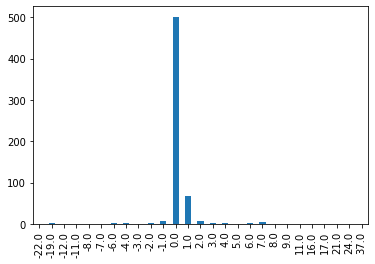

In [ ]:
fig1 = plt.gcf()
pd.value_counts(result['Predicted'].round(0)).sort_index().plot(kind="bar")

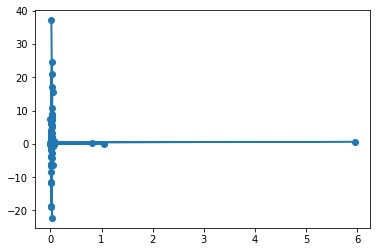

In [ ]:
plt.scatter(test_labels, test_predictions )
plt.plot(test_labels, test_predictions)

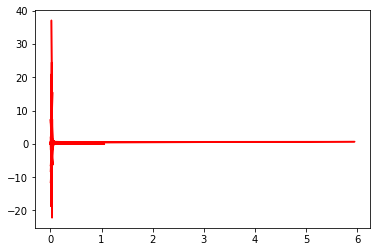

In [ ]:
plt.plot(test_labels, test_predictions, c = 'red')

In [ ]:
spec=test_labels.to_numpy()

In [ ]:
outlier=(spec-test_predictions)/(1+spec)

In [ ]:
outlier

array([[ 0.70078618,  0.70104264,  0.95535461, ...,  0.6987448 ,
         0.6939872 ,  0.69773277],
       [-0.55768105, -0.55634591,  0.76758001, ..., -0.56830827,
        -0.59307592, -0.57357684],
       [-0.61398795, -0.61260454,  0.75917851, ..., -0.62499932,
        -0.65066226, -0.63045834],
       ...,
       [-0.47748702, -0.47622062,  0.77954568, ..., -0.48756712,
        -0.51105965, -0.49256445],
       [ 0.0585892 ,  0.05939611,  0.85953306, ...,  0.05216646,
         0.03719771,  0.04898231],
       [ 0.09619113,  0.09696582,  0.86514361, ...,  0.09002493,
         0.07565407,  0.08696796]])

In [ ]:
f=pd.DataFrame(outlier)

In [ ]:
f[0].median()

0.0067375932746843795

In [ ]:
f[0].mean()

-0.21906062462674888